# Misc KBO planning calculations

This notebook contains calculations relevant to estimating the brightness distant KBO observations, specifically at high phase for rings detections via the phase curve. These are nominally planned with LORRI, but the question is whether 

### Initialize Python

In [76]:
import astropy.units as u
import astropy.constants as c
import math
import numpy as np
import matplotlib.pyplot as plt
import pymiecoated

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) # Caused by pymiecoated 

import matplotlib                                    # Set latex to use *not* CMR.
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'

r2d = 360 / (2*math.pi)
d2r = 1/r2d

### Look at brightness of Chariklo vs. its ring
We do a simple calculation: just look at the total cross-section of Chariklo, vs. the cross-section of its rings, at zero phase.

For comparison, we also do the same with MU69: take its cross-section, compared with the rings of Chariklo. (MU69 is much smaller than Chariklo, but here for an extreme case we assume it has Chariklo's ring system.)

In [77]:
r_chariklo = 315*u.km

r_ring = np.array([396, 405])*u.km
dr_ring = np.array([7, 3.5])*u.km
tau_ring = np.array([0.4, 0.06])

r_mu69 = 20*u.km

In [78]:
area_chariklo = math.pi * (r_chariklo**2)
area_mu69 = math.pi * (r_mu69**2)
area_ring = np.sum( 2 *math.pi * (r_ring * dr_ring) * tau_ring )

In [79]:
area_ring / area_chariklo

<Quantity 0.024063492063492065>

In [80]:
area_ring / area_mu69

<Quantity 5.96925>

In [81]:
area_ring.to('km^2')

<Quantity 7501.180778976349 km2>

Conclusion: For Chariklo, the total surface area of the ring is only a few percent. For MU69, ring area > KBO area (for the assumptions made here.)

But this is at backscatter. As we move to forward-scatter, the KBO will get fainter, and the ring will likely get brighter. This would not be a subtle effect. It could totally dominate the phase curve. 

Below I calculate this in more detail.

### Calculate DN of KBO observation

What we want here:
* Assume a v=20 KBO, at 140 deg phase. This is the worst case. Calculate DN/pixel/sec for this.
* Calculate the stray light in LORRI. Hal's table gives this in I/F, and we can convert this to DN/sec/pixel.
* One of these conversions uses unresolved. One uses resolved. So, we use RSOLAR and PSOLAR.

To convert to DN, we use standard LORRI RT equations:<br>
`V = -2.5 log S + PHOTZPT + CC + BC`<br>
     i.e.,<br>
`S = exp((BC + CC + PHOTZPT - V) / 2.5)`<br>
* `V` = mag
* `PHOTZPT` = zero pount for LORRI = 18.94 (from Hal's paper)
* `CC` = Color Correction. Assume zero since reflected solar.
* `S` = Integrated net signal rate from target, in DN/sec
* `BC` = Aperture Correction. Assume zero.

In [82]:
V         = 20    # V mag of distant KBO
phase_deg = 140   # Phase angle, in degrees
PHOTZPT   = 18.94 # LORRI Photometric z-point
F         = 176   # Solar flux

## Now look at stray light and the signal from KBO and its ring

Conventions to adopt here:
* All angles are the phase angle $\phi$. 180 = forward; 0 = backscatter.
* Scattering angle is $\alpha$, but I try not to use it. My papers also use $\theta$ to be scattering angle.
* Hal's plot of stray light is *opposite* to this ('Angle from sun'). I don't use his convention.
* Keep all angles internally in radians

### Define the stray light function at Pluto, from LORRI observations

In [83]:
IoF_stray_lorri_pluto_arr = np.transpose(np.array([
                        [0.1, 100], # Take the raw data from Hal's plot. Angle from sun in Deg, and I/F.
                        [1, 10],    # I/F values are indep of distance.
                        [2, 1],
                        [15, 1.5e-2],
                        [20, 2e-3],
                        [25, 1e-3],
                        [30, 8e-4],
                        [50, 1e-4],
                        [60, 3e-5],
                        [75,1e-5]]))

dist_pluto_ca_au   = 33             # NH heliocentric distance at Pluto flyby, in AU

### Flip this around so it's a function of phase angle (not scattering angle).

In [84]:
angle_stray           = IoF_stray_lorri_pluto_arr[0,:]
phi_stray             = (180 - angle_stray) * d2r # Phase angle, in radians
IoF_stray_lorri_pluto = IoF_stray_lorri_pluto_arr[1,:]

# Convert Hal's chart values from I/F, to DN, using normalization constant on that chart.

S_stray_lorri_pluto   = IoF_stray_lorri_pluto * (10 / 8e-4) # DN/sec/pixel [blue dashed line in Hal's slide]
                                                            # DN/sec is for Pluto distance.
                                                            # For other distances, multiply by (33/dist_au)**2

### Make a test plot of stray light, to compare to Hal's plot

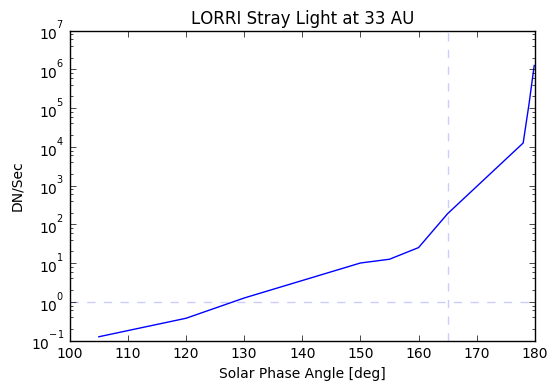

In [85]:
plt.plot(phi_stray*r2d, S_stray_lorri_pluto)
plt.yscale('log')
plt.xlabel('Solar Phase Angle [deg]')
plt.ylabel('DN/Sec')
plt.title('LORRI Stray Light at 33 AU')
plt.axhline(1,linestyle='--', alpha=0.2)    # 1 DN/sec
plt.axvline(165,linestyle='--', alpha=0.2)  # Outbound asymptote
plt.show()

### Define a Lambertian phase function

In [86]:
def phase_function_lambert(phi):
    '''Returns phase function, given phase angle phi in radians. '''
    return (8/(3*math.pi) * (np.sin(phi) + (math.pi - phi)*np.cos(phi) ))

### Define a Mie phase function

In [87]:
def phase_function_mie(x, n_refract, phi):
    '''Returns phase function, given phase angle phi in radians.'''
    p11 = [] # List for the output array (n_x  X  n_angles)

    alpha = math.pi - phi                               # alpha is scattering angle. Phi is phase angle.
    
    for x_i in x:
        mie    = pymiecoated.Mie(x=x_i,m=n_refract)
        p11_i  = []     # Create the output arrays for each individual angular phase function

        for a in alpha: # Loop over angle
            S12 = mie.S12(np.cos(a))                    # Get the Mie coefficient using pymiecoated library
            p11_i.append(np.abs(S12[0]**2 + S12[1]**2)) # Compute the amplitude at each angle

        p11_i = np.array(p11_i)                         # Save the result
        p11.append(p11_i)

    p11_arr = np.array(p11)
    p11_out = np.sum(p11_arr,0)                         # Average all the phase functions together into one

    dalpha = abs(alpha[1] - alpha[0]) 
    p11 = p11_out
    p11 = p11 * 2 / (np.sum(p11 * np.sin(alpha) * dalpha)) # Normalize the phase function integral to 2

    return p11

### Set  up parameters, and do some calculations to generate a phase curve for a solid body and a ring

In [88]:
num_phi   = 100
phi       = np.array(range(num_phi))*math.pi/num_phi # Phase angles
n_refract = complex(1.5, 1e-2)                       # Refractive index. Not really critical what we choose.
x         = np.array([40, 50, 52, 55, 60])           # Make a phase function that is a mean of all of these X values


p11_lambert    = phase_function_lambert(phi)                         # Solid body, lambertian curve 
p11_mie        = phase_function_mie(x, n_refract, phi)               # 'Normal' dusty rings


## Enter assumptions about KBO size, distance, and ring area

In [103]:
V               = 20  # Magnitude of KBO. Typical magnitudes, as seen from NH, are 15-20.
dist            = 35  # Orbital distance, in AU. KBO flybys are mostly 2017 - 2018, at distances 37 .. 42 AU.
ratio_ring_body = 0.01 # Brightness ratio, at backscatter. (ie, area ratio of rings : central_body)

### Do photometric calculations

In [104]:
# Create the phase function for the KBO body.
# S = count rate, in DN/sec

S_kbo         = math.exp((PHOTZPT - V)/2.5)            # Calculate LORRI DN/sec for unresolved source of a given mag
S_kbo_lambert = p11_lambert * (S_kbo / p11_lambert[0]) # Multiply this by a Lambertian phase func

# Create the phase function for the KBO rings. Use two models, for a dark and light ring

S_kbo_mie     = p11_mie * (S_kbo / p11_mie[0]) * ratio_ring_body


### And make a plot of the two phase curves, plus the stray light curve

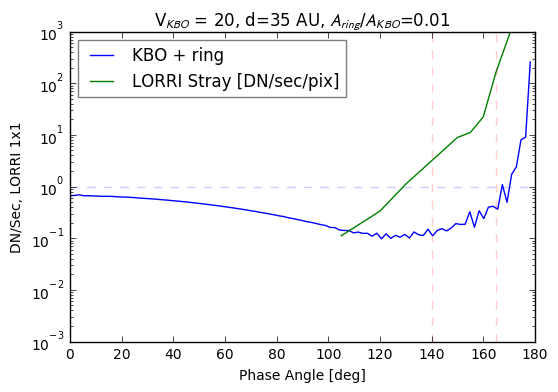

In [108]:
# plt.plot(phi*r2d,       S_kbo_lambert,       label = 'KBO Body [DN/sec]')
# plt.plot(phi*r2d,       S_kbo_mie,           label = 'KBO Rings [DN/sec]')
plt.plot(phi*r2d,       S_kbo_lambert + S_kbo_mie, label = 'KBO + ring' )
plt.plot(phi_stray*r2d, S_stray_lorri_pluto * (dist_pluto_ca/dist)**2, label = 'LORRI Stray [DN/sec/pix]')
plt.axhline(y=1, linestyle='--', alpha=0.2)                  # Horizontal dashed line at 1 DN/sec
plt.axvline(x=165, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at departure asymptote
plt.axvline(x=140, linestyle='--', color='red', alpha=0.2)   # Vertical dashed line at 140 deg (end of KBO 2016 obs)

plt.ylabel('DN/Sec, LORRI 1x1')
plt.xlabel('Phase Angle [deg]')
plt.yscale('log')
plt.legend(framealpha=0.5, loc = 'upper left')
plt.ylim((1e-3, 1000))
plt.title('V$_{{KBO}}$ = {}, d={} AU, $A_{{ring}}$/$A_{{KBO}}$={}'.format(V, dist, ratio_ring_body))

### Concl: 
I've done a bunch of cases. In all of them, LORRI stray light really dominates past 140 deg.

I don't have a quantitative measurement here for MVIC stray light. But on rings obs on DOY 2015-202 and 2015-305, the post-reduction stray light in LORRI was 10-100x worse (in units of I/F) than MVIC (that is, after Tod removed stray light from both). Tod's algorithm probably reduced stray light by 10x, at 165 deg.